packages
==========

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D
import torchvision.transforms as T
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt


import gzip
import pickle

load data
================

get train, validate and test segment
-----------------------------

In [2]:
def dequantize(x, rng):
    """
    Adds noise to pixels to dequantize them.
    """
    return x + rng.rand(*x.shape) / 256.0

In [3]:
f = gzip.open('/content/drive/MyDrive/Colab Notebooks/AI_relative/Normalizing_flow/data/mnist.pkl.gz', 'rb')
trn, val, tst = pickle.load(f, encoding='latin1')
f.close


<bound method GzipFile.close of <gzip _io.BufferedReader name='/content/drive/MyDrive/Colab Notebooks/AI_relative/Normalizing_flow/data/mnist.pkl.gz' 0x7f5e46a274a8>>

dequantize of x
-------------------

In [4]:
# generate random state
rng = np.random.RandomState(42)

trn_x = trn[0] + rng.rand(*trn[0].shape) / 256.0
val_x = val[0] + rng.rand(*val[0].shape) / 256.0
tst_x = tst[0] + rng.rand(*tst[0].shape) / 256.0

logit_transform of x
-------------------

In [5]:
def logit(x):
    """
    Elementwise logit (inverse logistic sigmoid).
    :param x: numpy array
    :return: numpy array
    """
    return np.log(x / (1.0 - x))

In [6]:
alpha = 1.0e-6

trn_x = logit(alpha + (1 - 2*alpha) * trn_x)
val_x = logit(alpha + (1 - 2*alpha) * val_x)
tst_x = logit(alpha + (1 - 2*alpha) * tst_x)

label
------------------

In [7]:
trn_label = trn[1]
val_label = val[1]
tst_label = tst[1]

print(trn_label.shape, val_label.shape, tst_label.shape)

(50000,) (10000,) (10000,)


y
----------------

In [8]:
def one_hot_encode(labels, n_labels):
    """
    Transforms numeric labels to 1-hot encoded labels. Assumes numeric labels are in the range 0, 1, ..., n_labels-1.
    """

    assert np.min(labels) >= 0 and np.max(labels) < n_labels

    y = np.zeros([labels.size, n_labels])
    y[range(labels.size), labels] = 1

    return y

In [9]:
trn_y = one_hot_encode(trn_label, 10)
val_y = one_hot_encode(val_label, 10)
tst_y = one_hot_encode(tst_label, 10)

print(trn_y.shape, val_y.shape, tst_y.shape)

(50000, 10) (10000, 10) (10000, 10)


N
-----------

In [10]:
trn_N = trn_x.shape[0]
val_N = val_x.shape[0]
tst_N = tst_x.shape[0]

print(trn_N, val_N, tst_N)

50000 10000 10000


organize train and test dataset
------------------------

In [11]:
# join train and val data again
train_x = np.concatenate((trn_x, val_x), axis=0).astype(np.float32)
train_y = np.concatenate((trn_y, val_y), axis=0).astype(np.float32)

# construct datasets
train_dataset = TensorDataset(torch.from_numpy(train_x).cuda(), torch.from_numpy(train_y).cuda())
test_dataset  = TensorDataset(torch.from_numpy(tst_x.astype(np.float32)).cuda(),
                                torch.from_numpy(tst_y.astype(np.float32)).cuda())

print(train_dataset[1][0].size())

input_dims = (1, 28, 28)
label_size = 10
lam = alpha

torch.Size([784])


assemble class
-------------

In [35]:
train_dataset.input_dims = input_dims
train_dataset.input_size = int(np.prod(input_dims))
train_dataset.label_size = label_size
train_dataset.lam = lam

test_dataset.input_dims = input_dims
test_dataset.input_size = int(np.prod(input_dims))
test_dataset.label_size = label_size
test_dataset.lam = lam

In [38]:
train_loader = DataLoader(train_dataset, 100, shuffle=True)
test_loader = DataLoader(test_dataset, 100, shuffle=False)

EXECUTION
================
set parameters

In [12]:
input_order = 'sequential'
input_size = 3
hidden_size = 2
input_degrees = None
n_hidden = 1

create_masks
---------------------

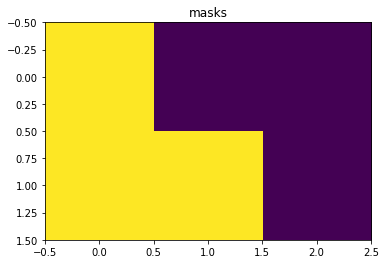

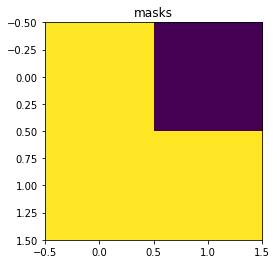

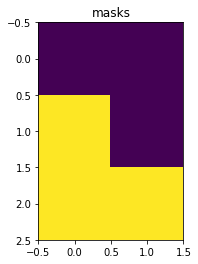

([tensor([[1., 0., 0.],
          [1., 1., 0.]]), tensor([[1., 0.],
          [1., 1.]]), tensor([[0., 0.],
          [1., 0.],
          [1., 1.]])], tensor([0, 1, 2]))

In [23]:
def create_masks(input_size, hidden_size, n_hidden, input_order='sequential', input_degrees=None):
    degrees = []

    # set input degrees to what is provided in args (the flipped order of the previous layer in a stack of mades);
    # else init input degrees based on strategy in input_order (sequential or random)
    if input_order == 'sequential':
        degrees += [torch.arange(input_size)] if input_degrees is None else [input_degrees]
        for _ in range(n_hidden + 1):
            degrees += [torch.arange(hidden_size) % (input_size - 1)]
        degrees += [torch.arange(input_size) % input_size - 1] if input_degrees is None else [input_degrees % input_size - 1]

    elif input_order == 'random':
        degrees += [torch.randperm(input_size)] if input_degrees is None else [input_degrees]
        for _ in range(n_hidden + 1):
            min_prev_degree = min(degrees[-1].min().item(), input_size - 1)
            degrees += [torch.randint(min_prev_degree, input_size, (hidden_size,))]
        min_prev_degree = min(degrees[-1].min().item(), input_size - 1)
        degrees += [torch.randint(min_prev_degree, input_size, (input_size,)) - 1] if input_degrees is None else [input_degrees - 1]

    # construct masks
    masks = []
    for (d0, d1) in zip(degrees[:-1], degrees[1:]):
        masks += [(d1.unsqueeze(-1) >= d0.unsqueeze(0)).float()]

    for m in masks:
        plt.imshow(m)
        plt.title("masks")
        plt.show()


    return masks, degrees[0]

create_masks(input_size, hidden_size, n_hidden)


MaskedLinear class
--------------

In [14]:
class MaskedLinear(nn.Linear):
    """ MADE building block layer """
    def __init__(self, input_size, n_outputs, mask, cond_label_size=None):
        super().__init__(input_size, n_outputs)

        self.register_buffer('mask', mask)

        self.cond_label_size = cond_label_size
        if cond_label_size is not None:
            self.cond_weight = nn.Parameter(torch.rand(n_outputs, cond_label_size) / math.sqrt(cond_label_size))

    def forward(self, x, y=None):
        out = F.linear(x, self.weight * self.mask, self.bias)
        if y is not None:
            out = out + F.linear(y, self.cond_weight)
        return out

    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        ) + (self.cond_label_size != None) * ', cond_features={}'.format(self.cond_label_size)

MADE class
-----------------

In [20]:
class MADE(nn.Module):
    def __init__(self, input_size, hidden_size, n_hidden, cond_label_size=None, activation='relu', input_order='sequential', input_degrees=None):
        """
        Args:
            input_size -- scalar; dim of inputs
            hidden_size -- scalar; dim of hidden layers
            n_hidden -- scalar; number of hidden layers
            activation -- str; activation function to use
            input_order -- str or tensor; variable order for creating the autoregressive masks (sequential|random)
                            or the order flipped from the previous layer in a stack of mades
            conditional -- bool; whether model is conditional
        """
        super().__init__()
        # base distribution for calculation of log prob under the model
        self.register_buffer('base_dist_mean', torch.zeros(input_size))
        self.register_buffer('base_dist_var', torch.ones(input_size))

        # create masks
        masks, self.input_degrees = create_masks(input_size, hidden_size, n_hidden, input_order, input_degrees)

        # setup activation
        if activation == 'relu':
            activation_fn = nn.ReLU()
        elif activation == 'tanh':
            activation_fn = nn.Tanh()
        else:
            raise ValueError('Check activation function.')

        # construct model
        self.net_input = MaskedLinear(input_size, hidden_size, masks[0], cond_label_size).cuda()
        self.net = []
        for m in masks[1:-1]:
            self.net += [activation_fn, MaskedLinear(hidden_size, hidden_size, m).cuda()]
        self.net += [activation_fn, MaskedLinear(hidden_size, 2 * input_size, masks[-1].repeat(2,1)).cuda()]
        self.net = nn.Sequential(*self.net)

    @property
    def base_dist(self):
        return D.Normal(self.base_dist_mean, self.base_dist_var)

    def forward(self, x, y=None):
        # MAF eq 4 -- return mean and log std
        m, loga = self.net(self.net_input(x, y)).chunk(chunks=2, dim=1)
        u = (x - m) * torch.exp(-loga)
        # MAF eq 5
        log_abs_det_jacobian = - loga
        return u, log_abs_det_jacobian

    def inverse(self, u, y=None, sum_log_abs_det_jacobians=None):
        # MAF eq 3
        D = u.shape[1]
        x = torch.zeros_like(u)
        # run through reverse model
        for i in self.input_degrees:
            m, loga = self.net(self.net_input(x, y)).chunk(chunks=2, dim=1)
            x[:,i] = u[:,i] * torch.exp(loga[:,i]) + m[:,i]
        log_abs_det_jacobian = loga
        return x, log_abs_det_jacobian

    def log_prob(self, x, y=None):
        u, log_abs_det_jacobian = self.forward(x, y)
        return torch.sum(self.base_dist.log_prob(u) + log_abs_det_jacobian, dim=1)


BatchNormal
----------------------

In [26]:
class BatchNorm(nn.Module):
    """ RealNVP BatchNorm layer """
    def __init__(self, input_size, momentum=0.9, eps=1e-5):
        super().__init__()
        self.momentum = momentum
        self.eps = eps

        self.log_gamma = nn.Parameter(torch.zeros(input_size))
        self.beta = nn.Parameter(torch.zeros(input_size))

        self.register_buffer('running_mean', torch.zeros(input_size))
        self.register_buffer('running_var', torch.ones(input_size))

    def forward(self, x, cond_y=None):
        if self.training:
            self.batch_mean = x.mean(0)
            self.batch_var = x.var(0) # note MAF paper uses biased variance estimate; ie x.var(0, unbiased=False)

            # update running mean
            self.running_mean.mul_(self.momentum).add_(self.batch_mean.data * (1 - self.momentum))
            self.running_var.mul_(self.momentum).add_(self.batch_var.data * (1 - self.momentum))

            mean = self.batch_mean
            var = self.batch_var
        else:
            mean = self.running_mean
            var = self.running_var

        # compute normalized input (cf original batch norm paper algo 1)
        x_hat = (x - mean) / torch.sqrt(var + self.eps)
        y = self.log_gamma.exp() * x_hat + self.beta

        # compute log_abs_det_jacobian (cf RealNVP paper)
        log_abs_det_jacobian = self.log_gamma - 0.5 * torch.log(var + self.eps)
#        print('in sum log var {:6.3f} ; out sum log var {:6.3f}; sum log det {:8.3f}; mean log_gamma {:5.3f}; mean beta {:5.3f}'.format(
#            (var + self.eps).log().sum().data.numpy(), y.var(0).log().sum().data.numpy(), log_abs_det_jacobian.mean(0).item(), self.log_gamma.mean(), self.beta.mean()))
        return y, log_abs_det_jacobian.expand_as(x)

    def inverse(self, y, cond_y=None):
        if self.training:
            mean = self.batch_mean
            var = self.batch_var
        else:
            mean = self.running_mean
            var = self.running_var

        x_hat = (y - self.beta) * torch.exp(-self.log_gamma)
        x = x_hat * torch.sqrt(var + self.eps) + mean

        log_abs_det_jacobian = 0.5 * torch.log(var + self.eps) - self.log_gamma

        return x, log_abs_det_jacobian.expand_as(x)

FlowSequential
-----------------------

In [27]:
class FlowSequential(nn.Sequential):
    """ Container for layers of a normalizing flow """
    def forward(self, x, y):
        sum_log_abs_det_jacobians = 0
        for module in self:
            x, log_abs_det_jacobian = module(x, y)
            sum_log_abs_det_jacobians = sum_log_abs_det_jacobians + log_abs_det_jacobian
        return x, sum_log_abs_det_jacobians

    def inverse(self, u, y):
        sum_log_abs_det_jacobians = 0
        for module in reversed(self):
            u, log_abs_det_jacobian = module.inverse(u, y)
            sum_log_abs_det_jacobians = sum_log_abs_det_jacobians + log_abs_det_jacobian
        return u, sum_log_abs_det_jacobians

MAF class
--------------------

In [17]:
class MAF(nn.Module):
    def __init__(self, n_blocks, input_size, hidden_size, n_hidden, cond_label_size=None, activation='relu', input_order='sequential', batch_norm=True):
        super().__init__()
        # base distribution for calculation of log prob under the model
        self.register_buffer('base_dist_mean', torch.zeros(input_size))
        self.register_buffer('base_dist_var', torch.ones(input_size))

        # construct model
        modules = []
        self.input_degrees = None
        for i in range(n_blocks):
            modules += [
                MADE(input_size, hidden_size, n_hidden, cond_label_size, activation, input_order, self.input_degrees).cuda()]
            self.input_degrees = modules[-1].input_degrees.flip(0)
            modules += batch_norm * [BatchNorm(input_size)]

        self.net = FlowSequential(*modules)

    @property
    def base_dist(self):
        return D.Normal(self.base_dist_mean, self.base_dist_var)

    def forward(self, x, y=None):
        return self.net(x, y)

    def inverse(self, u, y=None):
        return self.net.inverse(u, y)

    def log_prob(self, x, y=None):
        u, sum_log_abs_det_jacobians = self.forward(x, y)
        return torch.sum(self.base_dist.log_prob(u) + sum_log_abs_det_jacobians, dim=1)

train_and_evaluate
------------------------

In [45]:
def train_and_evaluate(model, train_loader, test_loader, optimizer, args):
    best_eval_logprob = float('-inf')

    for i in range(0, 0 + 100):
        train(model, train_loader, optimizer, i, args)
        eval_logprob, _ = evaluate(model, test_loader, i, args)

        # save training checkpoint
        torch.save({'epoch': i,
                    'model_state': model.state_dict(),
                    'optimizer_state': optimizer.state_dict()},
                    os.path.join(args.output_dir, 'model_checkpoint.pt'))
        # save model only
        torch.save(model.state_dict(), os.path.join(args.output_dir, 'model_state.pt'))

        # save best state
        if eval_logprob > best_eval_logprob:
            best_eval_logprob = eval_logprob
            torch.save({'epoch': i,
                        'model_state': model.state_dict(),
                        'optimizer_state': optimizer.state_dict()},
                        os.path.join(args.output_dir, 'best_model_checkpoint.pt'))

        # plot sample
        if args.dataset == 'TOY':
            plot_sample_and_density(model, train_loader.dataset.base_dist, args, step=i)
        if args.dataset == 'MNIST':
            generate(model, train_loader.dataset.lam, args, step=i)

run
==================

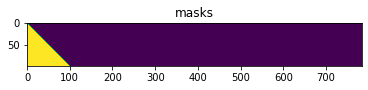

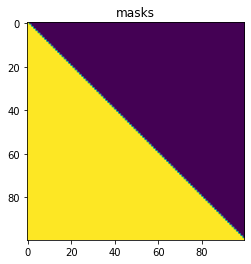

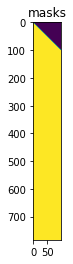

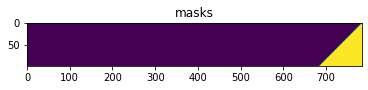

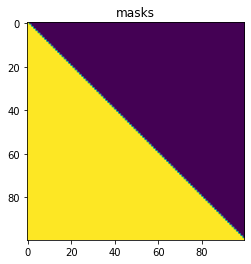

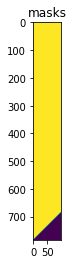

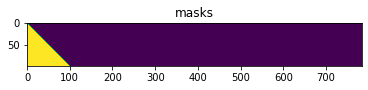

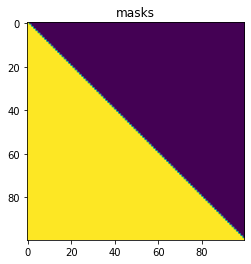

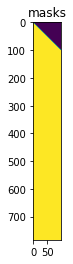

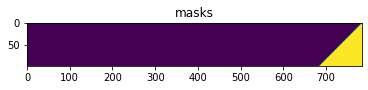

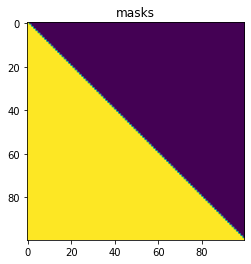

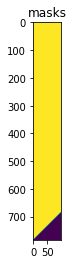

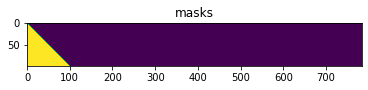

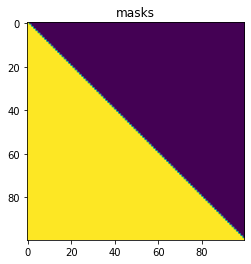

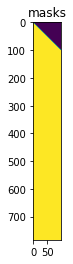

In [28]:
model = MAF(5, 784, 100, 1, None,
                    'relu', 'sequential', batch_norm=not False)

In [43]:
optimizer = torch.optim.Adam(model.parameters(), 0.0001, weight_decay=1e-6)

In [44]:
train_and_evaluate(model, train_loader, test_loader, optimizer, )

TypeError: ignored